In [1]:
import sys
import os
from pathlib import Path
import logging
from getpass import getpass

import contextily as cx
import geobr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tobler.area_weighted import area_interpolate

In [2]:
# --- 1. DEVELOPER SETUP (Path Injection) ---
# Ensures we can import 'atlasbr' even if it's not installed via pip.
current_path = Path(os.getcwd())

# Try to find project root
if current_path.name == "tutorials":
    root_dir = current_path.parent
else:
    root_dir = current_path

# Inject path (supports both src and flat layouts)
src_dir = root_dir / "src"
if src_dir.exists():
    sys.path.insert(0, str(src_dir)) 
else:
    sys.path.insert(0, str(root_dir))

import atlasbr

In [3]:
# --- 2. CONFIGURATION ---

# A. Logging
atlasbr.configure_logging(level=logging.INFO)
print(f"✅ AtlasBR version {getattr(atlasbr, '__version__', 'dev')} loaded.")

# B. Authentication
project_id = os.getenv("GOOGLE_CLOUD_PROJECT") or os.getenv("GCLOUD_PROJECT_ID")
if not project_id:
    project_id = getpass("Enter Google Cloud Project ID: ")

try:
    atlasbr.set_billing_id(project_id.strip())
    print("✅ Billing ID configured.")
except Exception as e:
    print(f"❌ Auth failed: {e}")

# C. Data Directory
# We manually define where the data is relative to this notebook
if current_path.name == "tutorials":
    # If we are in tutorials/, data is one level up
    data_dir = current_path.parent / "data"
else:
    # If we are in root, data is right here
    data_dir = current_path / "data"

# Create it if it doesn't exist, just to be safe
data_dir.mkdir(parents=True, exist_ok=True)

✅ AtlasBR version 0.1.0 loaded.
✅ Billing ID configured.


# Input Data

In [4]:
places = (
    geobr
    .read_metro_area()
    .query(
        "name_metro == 'RM Rio de Janeiro'"
        )
    .astype({'code_muni': 'int'})
    .code_muni
    )

places

752    3300456
753    3300803
754    3301702
755    3301850
756    3301900
757    3302007
758    3302270
759    3302502
760    3302700
761    3302858
762    3303203
763    3303302
764    3303500
765    3303609
766    3304144
767    3304300
768    3304557
769    3304904
770    3305109
771    3305554
772    3305752
Name: code_muni, dtype: int32

In [5]:
# Load Census data, but output as H3 Hexagons (Resolution 8)
gdf_2010 = atlasbr.load_census(
    places=places,
    year=2010,
    themes=["income", "basic"],
    clip_urban=True,
    geometry="tract",
)

2025-11-28 18:11:54,128 - atlasbr - INFO - Fetching municipality metadata from geobr...
2025-11-28 18:11:54,460 - atlasbr - INFO - 🔄 Resolved 21 inputs into 21 unique municipalities.
2025-11-28 18:11:54,461 - atlasbr - INFO - Fetching Census Tracts for 21 municipalities (Year 2010)...
2025-11-28 18:11:58,488 - atlasbr - INFO -     ✂️  Clipping to Urban Area...
2025-11-28 18:11:58,489 - atlasbr - INFO - Downloading Urban Areas (Epoch 2019) from IBGE...
2025-11-28 18:15:52,597 - atlasbr - INFO -        -> Retained 20031 tracts after clip.
2025-11-28 18:15:52,598 - atlasbr - INFO -     📦 Loading theme: 'income'...


    ☁️  Fetching 1 columns from basedosdados.br_ibge_censo_demografico.setor_censitario_basico_2010...
Downloading: 100%|██████████|

2025-11-28 18:15:54,741 - atlasbr - INFO -     📦 Loading theme: 'basic'...



    ☁️  Fetching 2 columns from basedosdados.br_ibge_censo_demografico.setor_censitario_basico_2010...
Downloading: 100%|██████████|

2025-11-28 18:15:57,262 - atlasbr - INFO - ✅ Loaded Census 2010 for 21 municipalities.


In [6]:
# Load Census data, but output as H3 Hexagons (Resolution 8)
gdf_2022 = atlasbr.load_census(
    places=places,
    year=2022,
    themes=["income", "basic"],
    clip_urban=True,
    geometry="tract",
)

2025-11-28 18:15:57,287 - atlasbr - INFO - 🔄 Resolved 21 inputs into 21 unique municipalities.
2025-11-28 18:15:57,288 - atlasbr - INFO - Fetching Census Tracts for 21 municipalities (Year 2022)...
2025-11-28 18:16:04,134 - atlasbr - INFO -     ✂️  Clipping to Urban Area...
2025-11-28 18:16:04,135 - atlasbr - INFO - Downloading Urban Areas (Epoch 2019) from IBGE...
2025-11-28 18:22:42,472 - atlasbr - INFO -        -> Retained 26823 tracts after clip.
2025-11-28 18:22:42,473 - atlasbr - INFO -     📦 Loading theme: 'income'...


    ⬇️  Downloading Income 2022 from FTP...


2025-11-28 18:22:45,183 - atlasbr - INFO -     📦 Loading theme: 'basic'...


    ☁️  Fetching 2 columns from basedosdados.br_ibge_censo_2022.setor_censitario...
Downloading: 100%|██████████|

2025-11-28 18:22:48,261 - atlasbr - INFO - ✅ Loaded Census 2022 for 21 municipalities.


In [7]:
gdf = pd.concat([
    gdf_2010, gdf_2022
    ])

In [8]:
gdf.sample(5)

,geometry,rendimento_medio,domicilios,habitantes,year
id_setor_censitario,,,,,
330045605050136,"POLYGON ((665860.354 7485372.681, 665787.595 7...",2013.05,231.0,561.0,2022
330455705200158,"POLYGON ((671732.113 7470241.757, 671719.279 7...",1062.08,62.0,140.0,2022
330455705220149,"POLYGON ((655657.782 7469983.665, 655653.715 7...",594.51,222.0,658.0,2010
330455705210789,"POLYGON ((670832.717 7458286.721, 670831.13 74...",545.46,274.0,803.0,2010
330455705320048,"POLYGON ((677579.794 7468401.794, 677549.454 7...",509.80,368.0,1222.0,2010


In [9]:
tracts_by_place_and_year = []
for year in (2010, 2022):
    for place in places:
        df = (
            geobr
            .read_census_tract(code_tract=place, year=year)
            .reindex(
                columns=[
                    'code_tract',
                    'name_muni',
                    'name_neighborhood',
                    'name_subdistrict',
                    ]
                )
            .assign(year=year)
            .astype({'code_tract': np.int64})
            .astype({'code_tract': 'str'})
            .rename(columns={'code_tract': 'id_setor_censitario'})
        )

        tracts_by_place_and_year.append(df.copy())

tracts_by_place_and_year = pd.concat(tracts_by_place_and_year)

In [10]:
tracts_by_place_and_year.sample(5)

,id_setor_censitario,name_muni,name_neighborhood,name_subdistrict,year
13459,330320305000110,Nilópolis,Manoel Reis,None,2022
27963,330455705230172,Rio de Janeiro,Campo Grande,Campo Grande,2022
26785,330455705211446,Rio de Janeiro,Curicica,Jacarepaguá,2022
21193,330455705090334,Rio de Janeiro,Catete,Botafogo,2022
24392,330455705170641,Rio de Janeiro,Engenho de Dentro,Méier,2022


In [11]:
gdf = (
    gdf
    .merge(
        tracts_by_place_and_year,
        on=['id_setor_censitario', 'year'],
        how='left'
        )
)

In [12]:
gdf.sample(3)

,id_setor_censitario,geometry,rendimento_medio,domicilios,habitantes,year,name_muni,name_neighborhood,name_subdistrict
5116,330490410000285,"POLYGON ((704852.387 7467566.595, 704854.495 7...",446.82,24.0,70.0,2010,São Gonçalo,Arrastão,None
26314,330490405000705,"POLYGON ((704633.459 7474981.888, 704571.495 7...",4788.18,287.0,628.0,2022,São Gonçalo,Pedro Alcântara,None
42184,330455705250106,"POLYGON ((684988.742 7476698.875, 685037.851 7...",7073.39,225.0,535.0,2022,Rio de Janeiro,Jardim Guanabara,Ilha do Governador


# Plots

In [15]:
gdf['name_muni'] = gdf.name_muni.str.casefold()

In [134]:
df = gdf.groupby(
    ['name_muni', 'year'],
    ).agg({'habitantes': 'sum'}).unstack()


In [135]:
df

habitantes           
year                       2010       2022
name_muni                                 
belford roxo           468910.0   483087.0
cachoeiras de macacu    51528.0    55558.0
duque de caxias        854014.0   807942.0
guapimirim              51374.0    51682.0
itaboraí               217596.0   224267.0
itaguaí                108521.0   116514.0
japeri                  93252.0    96185.0
magé                   226212.0   228127.0
maricá                 127224.0   197197.0
mesquita               168301.0   167127.0
nilópolis              157296.0   146774.0
niterói                484918.0   481749.0
nova iguaçu            795308.0   785789.0
paracambi               45355.0    41100.0
queimados              137760.0   140523.0
rio bonito              54275.0    54983.0
rio de janeiro        6283486.0  6211223.0
seropédica              77495.0    80596.0
são gonçalo            997950.0   896744.0
são joão de meriti     458403.0   440962.0
tanguá                  30440.0    30888.0

(605442.2217445967, 769454.7967957082, 7443800.291514929, 7528348.258038833)

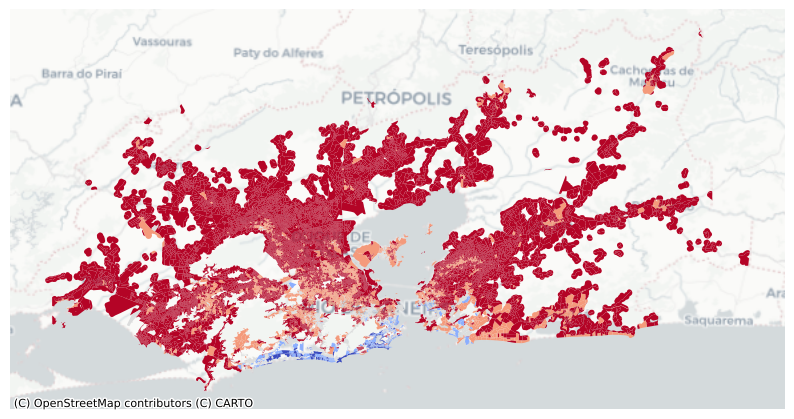

In [17]:
_, ax = plt.subplots(figsize=(10, 8))

gdf.query("year == 2010").plot(
    ax=ax,
    column='rendimento_medio',
    scheme='NaturalBreaks',
    cmap='coolwarm_r',
)

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron,
    crs=gdf.crs
)
ax.axis('off')


(605436.1408514893, 769582.495550963, 7443797.360887652, 7528409.733364713)

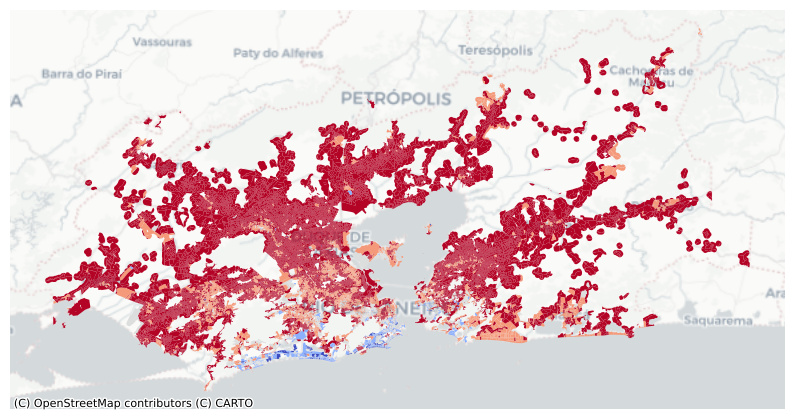

In [18]:
_, ax = plt.subplots(figsize=(10, 8))

# No caso, rendimento medio dos responsaveis pelos domicílios
gdf.query("year == 2022").plot(
    ax=ax,
    column='rendimento_medio',
    scheme='NaturalBreaks',
    cmap='coolwarm_r',
)

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron,
    crs=gdf.crs
)
ax.axis('off')


# Zonas

In [119]:
zonas = gpd.read_file(
    data_dir / 'Zoneamento_2012.zip'
).set_index('Zona')[['geometry']].to_crs(31983)

In [120]:
for year in (2010, 2022):
    zona_interpolated = area_interpolate(
        gdf[gdf.year == year].fillna(0),
        zonas,
        extensive_variables=['habitantes', 'domicilios'],
        intensive_variables=['rendimento_medio'],
    )

    zonas[f'habitantes_{year}'] = zona_interpolated['habitantes']
    zonas[f'domicilios_{year}'] = zona_interpolated['domicilios']
    zonas[f'rendimento_medio_{year}'] = zona_interpolated['rendimento_medio']

In [121]:
cities = (
    geobr
    .read_metro_area()
    .query(
        "name_metro == 'RM Rio de Janeiro'"
        )
    [['name_muni', 'geometry']]
    ).to_crs(31983)

In [122]:
zonas['name_muni'] = zonas.centroid.to_frame().sjoin(
    cities,
    how='left',
    predicate='intersects'
).name_muni

In [123]:
zonas.sample(5)

,geometry,habitantes_2010,domicilios_2010,rendimento_medio_2010,habitantes_2022,domicilios_2022,rendimento_medio_2022,name_muni
Zona,,,,,,,,
350.0,"POLYGON ((667728.89 7464596.934, 667728.774 74...",33925.000175,12096.000000,1321.932111,32165.999193,15980.331839,3945.591406,Rio De Janeiro
306.0,"POLYGON ((663950.615 7474944.083, 663997.983 7...",26825.999601,8689.999886,681.257023,22640.456538,10457.254806,2229.422539,Rio De Janeiro
187.0,"POLYGON ((672175.34 7477495.424, 672295.457 74...",25217.998672,8129.999643,769.807186,20269.870651,9792.424523,2568.889510,Rio De Janeiro
61.0,"POLYGON ((681227.519 7469709.775, 681122.59 74...",29336.998066,9288.999363,470.153288,32765.217148,13724.078076,1218.299528,Rio De Janeiro
340.0,"POLYGON ((685178.171 7465114.075, 685183.528 7...",21864.999055,7944.999658,1444.087567,19915.220846,10396.086655,4245.227557,Rio De Janeiro


In [124]:
df1 = (
    zonas
    .groupby(['name_muni'])
    .agg({
        'habitantes_2010': 'sum',
        'habitantes_2022': 'sum',
        'domicilios_2010': 'sum',
        'domicilios_2022': 'sum',
        'rendimento_medio_2010': 'mean',
        'rendimento_medio_2022': 'mean',
    })
    )

In [125]:
df1

,habitantes_2010,habitantes_2022,domicilios_2010,domicilios_2022,rendimento_medio_2010,rendimento_medio_2022
name_muni,,,,,,
Belford Roxo,4.829030e+05,4.851009e+05,1.502260e+05,2.006961e+05,461.293996,1558.358681
Duque De Caxias,8.540140e+05,8.081032e+05,2.693330e+05,3.549619e+05,529.733147,1938.064717
Guapimirim,5.182700e+04,5.231152e+04,1.586800e+04,2.605228e+04,500.262818,2704.995412
Itaboraí,2.198000e+05,2.262863e+05,7.011700e+04,1.123203e+05,487.332496,1592.505100
Itaguaí,9.973200e+04,1.006837e+05,3.111700e+04,4.988803e+04,537.866051,1895.475821
Japeri,9.325200e+04,9.626685e+04,2.840900e+04,3.902611e+04,388.064237,1431.006218
Magé,2.262120e+05,2.276725e+05,7.039400e+04,1.099627e+05,491.857145,1516.625771
Maricá,1.272240e+05,1.971974e+05,4.278300e+04,1.064262e+05,759.042245,2617.471901
Mesquita,1.683010e+05,1.670462e+05,5.310300e+04,6.669655e+04,641.941633,2180.295602


In [126]:
zonas.index = [f"{int(i):03}" for i in zonas.index]
zonas.index.name = 'ZT'

# Versao Anterior

In [127]:
rod = pd.read_excel(
    data_dir / 'ZONAS_RODRIGO_Versão03.xlsx'
)
rod['ZT'] = [f"{int(i):03}" for i in rod['ZT']]
rod = rod.set_index('ZT')

In [128]:
d = {
    'populacao 2010': 'habitantes_2010',
    'populacao 2022': 'habitantes_2022',
    'domicilios 2010': 'domicilios_2010',
    'domicilios 2022': 'domicilios_2022',
}
rod = rod.rename(columns=d)

In [129]:
rod = zonas[['geometry', 'name_muni']].merge(
    rod,
    left_index=True,
    right_index=True,
    )

<Axes: >

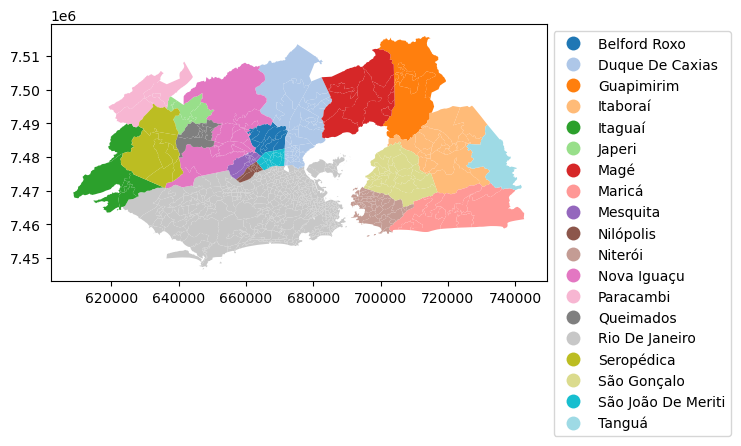

In [130]:
rod.plot(
    'name_muni', legend=True, cmap='tab20',
    legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}
    )

In [131]:
df2 = rod.groupby('name_muni').agg({
    'habitantes_2010': 'sum',
    'habitantes_2022': 'sum',
    'domicilios_2010': 'sum',
    'domicilios_2022': 'sum',
    })

In [142]:
# Versao Rodrigo
df2.astype(int)

,habitantes_2010,habitantes_2022,domicilios_2010,domicilios_2022
name_muni,,,,
Belford Roxo,484437,485815,150668,200950
Duque De Caxias,857948,808141,270263,354987
Guapimirim,51242,51762,15501,25969
Itaboraí,218133,225123,69593,111546
Itaguaí,100663,102246,31165,51097
Japeri,92016,95258,28051,38633
Magé,228365,228415,71150,109845
Maricá,127295,199249,42609,108245
Mesquita,164796,163377,52094,65361


In [141]:
# Versao Rodrigo - Versao Brandao
(df2-df1).fillna(0).astype(int)

,domicilios_2010,domicilios_2022,habitantes_2010,habitantes_2022,rendimento_medio_2010,rendimento_medio_2022
name_muni,,,,,,
Belford Roxo,441,253,1533,714,0,0
Duque De Caxias,930,25,3934,37,0,0
Guapimirim,-366,-83,-584,-549,0,0
Itaboraí,-523,-774,-1666,-1163,0,0
Itaguaí,48,1208,931,1562,0,0
Japeri,-357,-393,-1235,-1008,0,0
Magé,756,-117,2153,742,0,0
Maricá,-173,1818,71,2051,0,0
Mesquita,-1009,-1335,-3505,-3669,0,0


In [139]:
# "Versao IBGE"
df.astype(int)

habitantes         
year                       2010     2022
name_muni                               
belford roxo             468910   483087
cachoeiras de macacu      51528    55558
duque de caxias          854014   807942
guapimirim                51374    51682
itaboraí                 217596   224267
itaguaí                  108521   116514
japeri                    93252    96185
magé                     226212   228127
maricá                   127224   197197
mesquita                 168301   167127
nilópolis                157296   146774
niterói                  484918   481749
nova iguaçu              795308   785789
paracambi                 45355    41100
queimados                137760   140523
rio bonito                54275    54983
rio de janeiro          6283486  6211223
seropédica                77495    80596
são gonçalo              997950   896744
são joão de meriti       458403   440962
tanguá                    30440    30888

In [138]:
# Versao Brandao
df1.astype(int)

,habitantes_2010,habitantes_2022,domicilios_2010,domicilios_2022,rendimento_medio_2010,rendimento_medio_2022
name_muni,,,,,,
Belford Roxo,482903,485100,150226,200696,461,1558
Duque De Caxias,854013,808103,269332,354961,529,1938
Guapimirim,51826,52311,15867,26052,500,2704
Itaboraí,219799,226286,70116,112320,487,1592
Itaguaí,99731,100683,31116,49888,537,1895
Japeri,93251,96266,28408,39026,388,1431
Magé,226211,227672,70393,109962,491,1516
Maricá,127223,197197,42782,106426,759,2617
Mesquita,168301,167046,53103,66696,641,2180
